# Imports and inits

In [2]:
from typing_extensions import List, Optional, Union, TypedDict, Literal, Dict, Literal
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, BaseMessage, trim_messages, AIMessage
from langgraph.graph import END, StateGraph, START
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
from pprint import pprint
import functools
import operator

from team_tools import tavily_search_tool, arxiv_search_tool, web_scraper_tool, repl_tool

from qdrant_cloud_ops import initialize_selfquery_retriever, qdrant_vector_store
from chains import decomposition_chain, requires_decomposition, rephrase_chain
from typing import Annotated, List, Union, TypedDict
from langchain.tools.retriever import create_retriever_tool
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser



load_dotenv()

llm = ChatGroq(model='llama-3.2-90b-vision-preview')

trimmer = trim_messages(
    max_tokens=120000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)

qdrant_retriever = initialize_selfquery_retriever(llm, qdrant_vector_store=qdrant_vector_store)
qdrant_retriever_tool = qdrant_retriever.as_tool(
    name="retrieve_research_paper_texts",
    description="Search and return information from the vector database containing texts of several research papers, and scholarly articles",
)

dec = decomposition_chain(llm=llm)
rdec = requires_decomposition(llm=llm)


In [6]:
dec.invoke('what is positive energy?')

'What is the definition of energy?, What is meant by positive in the context of energy?, How does positive energy manifest or impact a system or individual?'

# prompts

In [8]:
rewoo_prompt = """
You will be given a string of simple question or questions seperated by comma. For each question, develop a series of sequential plans that specify exactly which agents to use to retrieve the necessary evidence. Format each plan in the following way:

Format:
Plan: [Provide a concise description of the intended action, including any specific sources, search queries, or steps that must be followed. Reference any evidence needed from previous steps.]
#E[number] = [Agent[Specific Query/Input, including any references to previous #E results if applicable]]

Use the minimum number of plans necessary to provide an accurate and relevant answer. Each plan should be followed by only one #E, with clear sequential ordering for reference by subsequent steps.
Strictly provide output only. Provide a complete plan that addresses all questions as a whole, instead of creating individual plans for each question.

Agents Available:
- RagSearcher[input]: Uses a vector database to retrieve relevant documents or research papers based on prior knowledge or pre-embedded content (use for tasks related to research papers in the form of PDFs or topics embedded in the database).
- Searcher[input]: Conducts searches via Tavily search, Web Scraper, or Arxiv Search to retrieve both general web information and academic papers from online sources.
- Coder[input]: A code-execution agent using Python REPL for tasks requiring code, data analysis, or visualizations.
- ChatBot[input]: Processes or generates natural language responses based on gathered evidence or specific input.

### Routing Guidance:
- For research papers or queries based on prior knowledge, use **RagSearcher** to pull from the vector database.
- For general online or web-based searches, use **Searcher**.
- For code or analysis tasks, use **Coder**.
- For summarization or extracting specific information from prior steps, use **ChatBot**.

Embedded Documents in the Vector Database:
   - "Attention is All You Need" (name: a.pdf)
   - "MAGVIT: Masked Generative Video Transformer" (name: m.pdf)
   - "SAN: Inducing Metrizability of GAN with Discriminative Normalized Linear Layer" (name: san.pdf)

### Advice:
- When creating each plan, ensure that the query given to the agent precisely reflects the questions received. This will help the agent retrieve the most relevant answer directly aligned with the original question.

### Examples
Task: Summarize recent advancements in Video Transformers for action recognition tasks.
Plan: Search for recent publications on Arxiv that discuss Video Transformers for action recognition using the Searcher agent. #E1 = Searcher[Video Transformers action recognition]
Plan: Retrieve related research papers on Video Transformers stored in the vector database using the RagSearcher agent. #E2 = RagSearcher[Video Transformers action recognition]
Plan: Use the retrieved documents to generate a summary highlighting advancements in the use of Video Transformers for action recognition. #E3 = ChatBot[Summarize #E1, #E2]

Task: Analyze the importance of GAN metrizability for improved performance in generative models.
Plan: Search Arxiv for recent studies on GAN metrizability and its impact on generative model performance using the Searcher agent. #E1 = Searcher[GAN metrizability and generative models]
Plan: Retrieve any embedded research on GAN metrizability from the vector database using the RagSearcher agent. #E2 = RagSearcher[GAN metrizability in generative models]
Plan: Summarize findings on why metrizability is significant for GAN performance based on the retrieved papers. #E3 = ChatBot[Summarize #E1, #E2]

Task: {task}

"""


rewoo_solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""

# utils

# state

In [9]:
from typing import List
from typing_extensions import TypedDict


class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

# procs

In [10]:
task = dec.invoke('abstract of san.pdf, what is Magvit? and what are recent research papwers on video trnaformers/').lower()
print(task)

# task = dec.invoke('abstract of san.pdf').lower()
# print(task)

what is magvit?, what is the abstract of san.pdf?, what are recent research papers on video transformers?


In [11]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", rewoo_prompt)])
planner = prompt_template | llm


def get_plan(state: ResearchTeamState):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

In [13]:
print(planner.invoke('abstract of san.pdf, how can we solve the problem of metriziability').content)

Plan: Retrieve the abstract of the embedded "SAN: Inducing Metrizability of GAN with Discriminative Normalized Linear Layer" research paper from the vector database using the RagSearcher agent. #E1 = RagSearcher[abstract of san.pdf]

Plan: Use the retrieved abstract to understand the problem of metrizability and identify potential solutions discussed in the paper. #E2 = ChatBot[Extract problem and solutions from #E1]

Plan: Search for additional research on solving metrizability problems in GANs using the Searcher agent. #E3 = Searcher[machine learning models for solving metrizability problem]

Plan: Analyze the retrieved information to provide a comprehensive answer on how to solve the problem of metrizability. #E4 = ChatBot[Combine #E2 and #E3 to provide an answer]


In [19]:
rag_agent = create_react_agent(llm, tools=[qdrant_retriever_tool])

search_agent = create_react_agent(llm, tools=[tavily_search_tool, arxiv_search_tool])

code_agent = create_react_agent(llm, tools=[repl_tool])

def chatbot(state: ResearchTeamState):
    return {"messages": [llm.invoke(state["messages"][-1].content)]}

In [14]:
def _get_current_task(state: ResearchTeamState):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ResearchTeamState):
    """Worker node that executes the tools of a given plan."""
    _results = (state["results"] or {}) if "results" in state else {}
    _step = _get_current_task(state)
    step_desc, step_name, agent, agent_input = state["steps"][_step - 1]
    for k, v in _results.items():
        agent_input = agent_input.replace(k, v)

    # Initialize `result` to a default value
    result = None

    if agent == "RagSearcher":
        result = rag_agent.invoke({"messages": [HumanMessage(content=agent_input)]})['messages'][-1].content
    elif agent == "Searcher":
        result = search_agent.invoke({"messages": [HumanMessage(content=agent_input)]})['messages'][-1].content
    elif agent == "ChatBot":
        result = llm.invoke(agent_input)
    elif agent == "Coder":
        result = code_agent.invoke({"messages": [HumanMessage(content=agent_input)]})['messages'][-1].content
    else:
        raise ValueError(f"Unknown agent type: {agent}")

    # Ensure `result` is not None before using it
    if result is None:
        raise ValueError(f"Agent {agent} did not return a result for step {step_name}")

    _results[step_name] = str(result)
    return {"results": _results}


In [15]:
solve_prompt = """SSolve the following task or problem. 
To solve the problem, we have made a step-by-step Plan and retrieved corresponding Evidence for each step. 
Use the Evidence with caution, as long evidence might contain irrelevant information.

{plan}

Now solve the question or task according to the provided Evidence above. For each subquestion, respond explicitly in a Q&A format. 

Task: {task}

Response:
Q1: [Subquestion 1]  
A1: [Answer to Subquestion 1 based on relevant Evidence]  

... (and so on for all subquestions)
"""


def solve(state: ResearchTeamState):
    plan = ""
    for _plan, step_name, agent, agent_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            agent_input = agent_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {agent}[{agent_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = llm.invoke(prompt)
    return {"result": result.content, 'messages': result}

In [16]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        return "solve"
    else:
        return "agent"

In [17]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ResearchTeamState)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

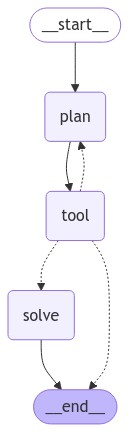

In [18]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))


{'plan': {'plan_string': 'Plan: Utilize the Coder agent to generate Python code for visualizing attention. #E1 = Coder[Python code for visualizing attention]\n\nPlan: Retrieve the research paper "Attention is All You Need" from the vector database using the RagSearcher agent. #E2 = RagSearcher[contents of a.pdf]\n\nPlan: Summarize the key components of the attention mechanism as described in the retrieved paper. #E3 = ChatBot[Summarize #E2]\n\nPlan: Refine the Python code to visualize attention based on the summarized components from the retrieved paper. #E4 = Coder[Visualize attention using components from #E3]\n\nPlan: Provide the final code snippet and its explanation for visualizing attention. #E5 = ChatBot[Explain #E4]', 'steps': [('Utilize the Coder agent to generate Python code for visualizing attention. ', '#E1', 'Coder', 'Python code for visualizing attention'), ('Retrieve the research paper "Attention is All You Need" from the vector database using the RagSearcher agent. ', '

Python REPL can execute arbitrary code. Use with caution.


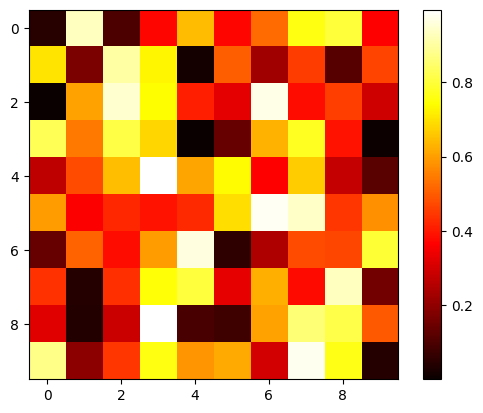

{'tool': {'results': {'#E1': 'This code will generate a random 10x10 attention matrix and display it as a heatmap. The heatmap will have a color bar on the right side, which represents the intensity of the attention. The `cmap="hot"` argument makes the heatmap use a color scheme where higher values are represented by hotter colors (i.e., colors closer to red). The `interpolation="nearest"` argument makes the heatmap use the nearest-neighbor interpolation method, which can make the heatmap look more pixelated.\n\nYou can replace the random attention matrix with your own attention matrix to visualize it.'}}}
---
{'tool': {'results': {'#E1': 'This code will generate a random 10x10 attention matrix and display it as a heatmap. The heatmap will have a color bar on the right side, which represents the intensity of the attention. The `cmap="hot"` argument makes the heatmap use a color scheme where higher values are represented by hotter colors (i.e., colors closer to red). The `interpolation=

In [29]:
for s in app.stream({"task": 'can you write a dummy code to visualize attention'}):
    print(s)
    print("---")

In [ ]:
# for s in rag_agent.stream({"messages": [HumanMessage(content="What's attention")]}):
#     print(s)

rag_agent.invoke({"messages": [HumanMessage(content="What's attention")]})['messages'][-1]

AIMessage(content='Attention, in the context of psychology and neuroscience, refers to the cognitive process of selectively concentrating on one aspect of the environment while ignoring other stimuli. It is a crucial mechanism that enables us to focus on relevant information, filter out distractions, and efficiently process sensory inputs.\n\nIn the context of the provided research paper, attention is used in a different sense. The paper discusses the Transformer model, a type of neural network architecture that relies entirely on attention mechanisms to draw global dependencies between input and output sequences. The model uses multi-head attention, which allows it to jointly attend to information from different representation subspaces at different positions.\n\nThe paper highlights the benefits of using attention mechanisms in sequence-to-sequence models, such as improved parallelization and reduced computational cost. It also discusses the applications of attention in the Transform

In [ ]:
# for s in search_agent.stream({"messages": [HumanMessage(content='what are some recent research papers that apply transformer architectures, specifically video transformers, to video-related tasks?')]}):
#     print(s)

search_agent.invoke({"messages": [HumanMessage(content='whats te difference between attentiona nd self attention and what are some recent research papers that apply transformer architectures, specifically video transformers, to video-related tasks?')]})['messages'][-1]

AIMessage(content='The difference between attention and self-attention is that attention is a mechanism that allows a model to focus on specific parts of the input data, while self-attention is a specific type of attention mechanism that allows a model to attend to different parts of the same input sequence.\n\nRecent research papers that apply transformer architectures, specifically video transformers, to video-related tasks include:\n\n* "Reinforcement Learning-based Mixture of Vision Transformers for Video Violence Recognition" by Hamid Mohammadi et al.\n* "Video Mamba Suite: State Space Model as a Versatile Alternative for Video Understanding" by Guo Chen et al.\n* "Towards Training Stronger Video Vision Transformers for EPIC-KITCHENS-100 Action Recognition" by Ziyuan Huang et al.\n* "An End-to-End Trainable Video Panoptic Segmentation Method using Transformers" by Jeongwon Ryu et al.\n* "Transformer-based Image and Video Inpainting: Current Challenges and Future Directions" by Oma

In [ ]:
tavily_search_tool.invoke('what is positron')

[{'url': 'https://home.cern/news/news/physics/still-making-tracks-eighty-years-positron',
  'content': "A positron is the antimatter counterpart of an electron, with opposite charge and identical mass. Learn how Carl Anderson discovered it in 1933, how it fits Dirac's prediction, and how it is used in particle physics and medicine."},
 {'url': 'https://byjus.com/chemistry/positron/',
  'content': 'A positron is a positively charged particle that is the antiparticle of an electron. Learn how it is produced, how it interacts with matter and how it is used in antihydrogen research.'},
 {'url': 'https://www.allthescience.org/what-is-a-positron.htm',
  'content': 'A positron is the antimatter equivalent of an electron, with a positive charge and a low mass. Learn about its discovery, properties, applications, and challenges in this article.'},
 {'url': 'https://www.vedantu.com/chemistry/positron',
  'content': 'A positron or antielectron is the antimatter counterpart to an electron. A posit

In [ ]:
llm_with_tools = llm.bind_tools(tools=[qdrant_retriever_tool, web_scraper_tool, tavily_search_tool, arxiv_search_tool])

In [ ]:
llm_with_tools.invoke('what is self attention')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7fqh', 'function': {'arguments': '{"query": "self-attention"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 599, 'total_tokens': 619, 'completion_time': 0.097139516, 'prompt_time': 0.101830235, 'queue_time': 0.006444657999999992, 'total_time': 0.198969751}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_07b97e5459', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-579f5bef-263e-42da-91b3-333b680ea46b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'self-attention'}, 'id': 'call_7fqh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 599, 'output_tokens': 20, 'total_tokens': 619})

In [ ]:
qdrant_retriever.invoke('self attention')

[Document(metadata={'pdf_id': 'a.pdf', '_id': '1313109e-8fe8-45cc-b249-a79821e51c1f', '_collection_name': 'aireas-cloud'}, page_content='of a single sequence in order to compute a representation of the sequence. Self-attention has been\nused successfully in a variety of tasks including reading comprehension, abstractive summarization,\ntextual entailment and learning task-independent sentence representations [4, 27, 28, 22].\nEnd-to-end memory networks are based on a recurrent attention mechanism instead of sequence-\naligned recurrence and have been shown to perform well on simple-language question answering and\nlanguage modeling tasks [34].\nTo the best of our knowledge, however, the Transformer is the first transduction model relying\nentirely on self-attention to compute representations of its input and output without using sequence-\naligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate\nself-attention and discuss its advantages over m